# 🐦 Computational Bioacoustics: An Interactive Introduction

Welcome to this interactive session on **computational bioacoustics**!  
We will learn how to process, visualize, and extract features from animal sound recordings.

---

## 📚 Objectives:
- Understand what computational bioacoustics is
- Learn how to load and visualize audio recordings
- Generate spectrograms to analyze frequency patterns
- Extract features from audio data
- Visualize how the input changes in different layers of the machine learning model

---

# 🔧 Setup: Install Required Libraries


In [1]:
# Uncomment and run this cell if you don't have the packages installed

# !pip install numpy matplotlib librosa ipywidgets


In [2]:
# 📦 Import Libraries

import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd



## 🎵 Load an Example Animal Sound
 
Load a `.WAV` file of an animal sound. This example uses a pre-recorded clip.  
We also listen to the audio and inspect the sample rate and duration.


In [3]:
# 🎵 Load an Example Animal Sound

# Load an example audio file (replace this with your own .wav file)
source_path = 'sources/243B1F08641FDBB4_20250503_040000.WAV'

y, sr = librosa.load(source_path, sr=48000)

print(f"Sample rate: {sr} Hz")
print(f"Audio duration: {len(y)/sr:.2f} seconds")

# ▶️ Play the sound
ipd.Audio(y, rate=sr)


Sample rate: 48000 Hz
Audio duration: 30.00 seconds


## 📈 Visualize the Waveform

Visualize the waveform of the loaded audio file.  
This helps understand amplitude variations over time.

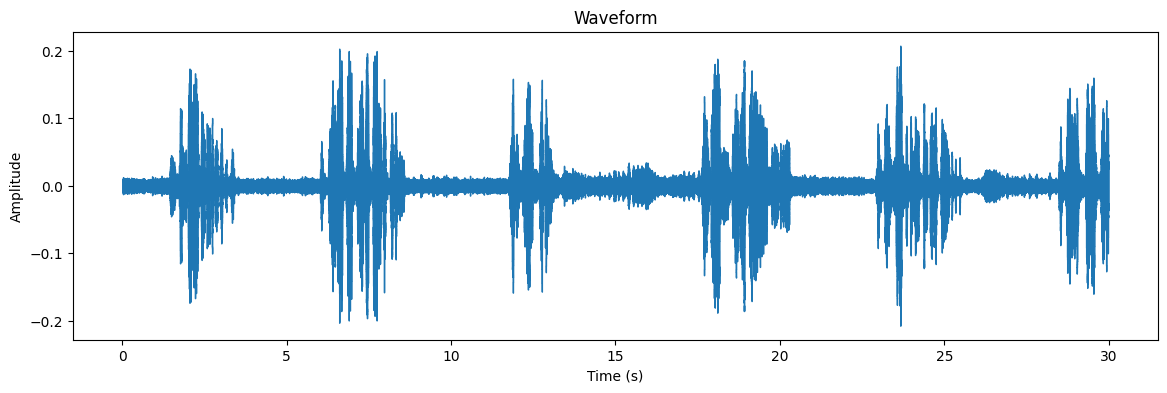

In [4]:
# 📈 Visualize the Waveform

plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


## 🌈 Generate a Spectrogram

A spectrogram is a visual representation of the spectrum of frequencies in a signal over time.  
We compute it using the Short-Time Fourier Transform (STFT).


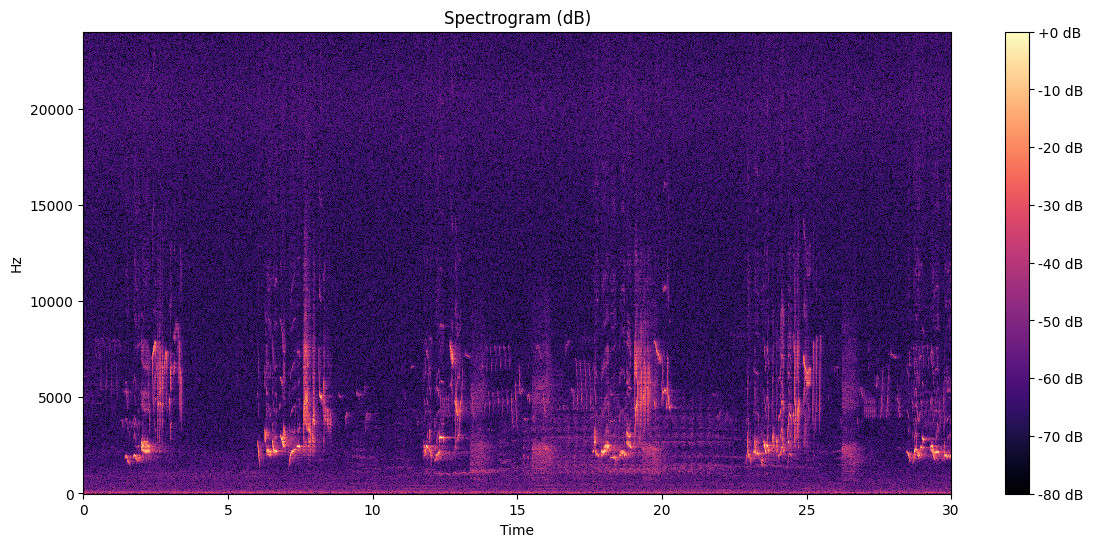

In [5]:
# 🌈 Generate a Spectrogram

# Compute the Short-Time Fourier Transform (STFT)
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(14, 6))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (dB)')
plt.show()


## 🔍 Zoom into a Segment
 
For a closer look, we isolate a 3-second window from the audio (from 6s to 9s) and generate a higher-resolution spectrogram.


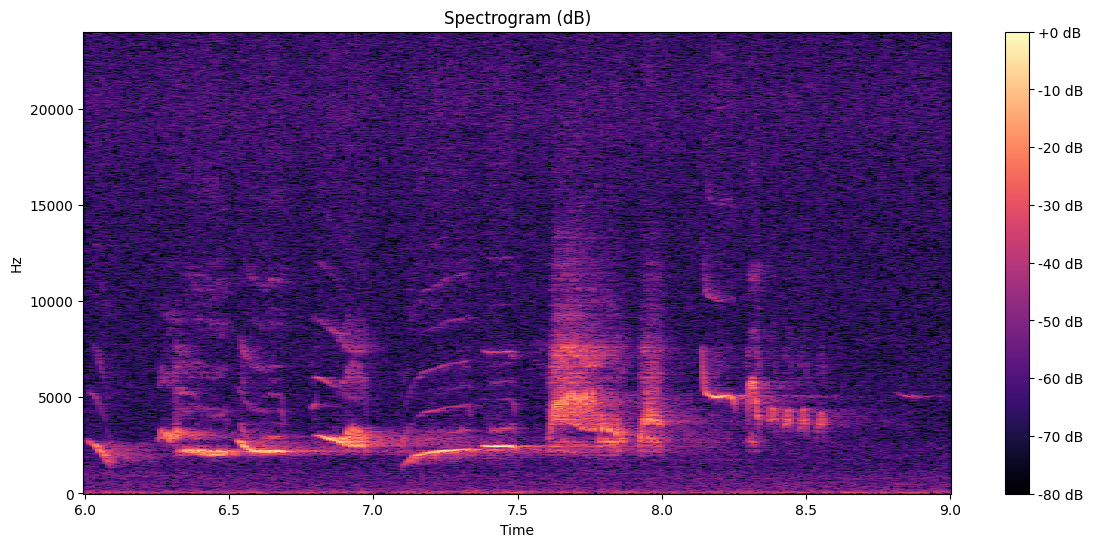

In [6]:
# Compute the Short-Time Fourier Transform (STFT)
beg = 6*sr
end = 9*sr
y_win = y[beg:end]
D = librosa.stft(y_win)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(14, 6))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
a, b = plt.xticks()
plt.xticks(a[1:-1], np.linspace(6, 9, 7))
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (dB)')
plt.show()



## 🧠 Load Pretrained BirdNET Model
 
Load a pre-trained BirdNET model to classify the audio sample.  
This model has been trained to recognize thousands of bird species from sound alone.

In [7]:
import tensorflow as tf


model = tf.keras.models.load_model('sources/birdnet')

## 🐦 Predict the Class of the Audio Sample

Use the model to make a prediction on the selected audio window.  
The predicted class index is mapped to a human-readable label.

In [8]:
import pandas as pd
labels_from_idx = pd.read_csv('sources/BirdNET_GLOBAL_6K_V2.4_Labels_en_uk.txt', header=None)

pred = np.argmax(model.model(y[beg:end].reshape(1, -1, 1)))
print(f"Predicted class: {labels_from_idx.iloc[pred, 0]}")

Predicted class: Turdus merula_Eurasian Blackbird


## 🔍 Inspect Internal Model Representation
 
We visualize the audio spectrogram again and compare it to what the model "hears" (internal spectrogram representation from a deep layer of the model).


1/1 [==============================] - 0s 169ms/step


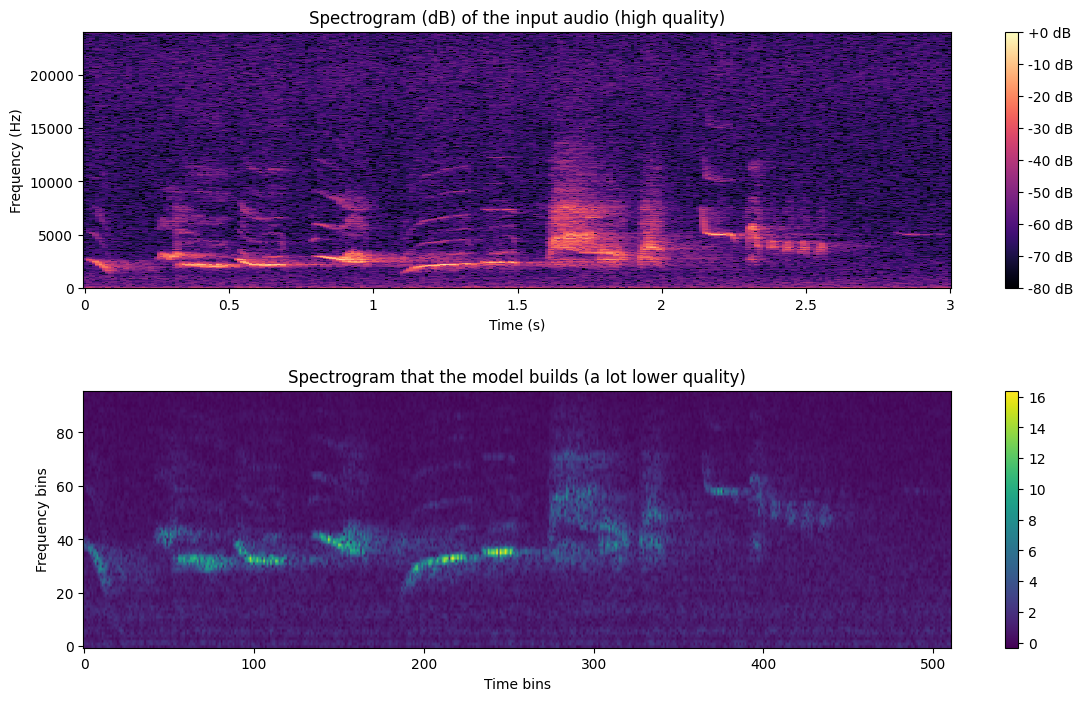

In [9]:
m = tf.keras.models.Model(inputs=model.model.input, outputs=model.model.layers[4].output)

plt.figure(figsize=(14, 8))
plt.subplots_adjust(hspace=0.4)
plt.subplot(2, 1, 1)
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
# plt.xticks(np.linspace(0, 511, 7), np.linspace(0, 3, 7))
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (dB) of the input audio (high quality)')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')

plt.subplot(2, 1, 2)
plt.imshow(m.predict(y[beg:end].reshape(1, -1, 1))[0,::-1,:,-1], aspect='auto', cmap='viridis', origin='lower')
plt.title('Spectrogram that the model builds (a lot lower quality)')
plt.ylabel('Frequency bins')
plt.xlabel('Time bins')
plt.colorbar()
plt.show()


### 🔬 Visualize Intermediate Layer Outputs
 
Let's go deeper inside the model and see how different filters in one of the convolutional layers respond to the input sound.  
This helps us understand what kind of patterns the model learns.

1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 124ms/step


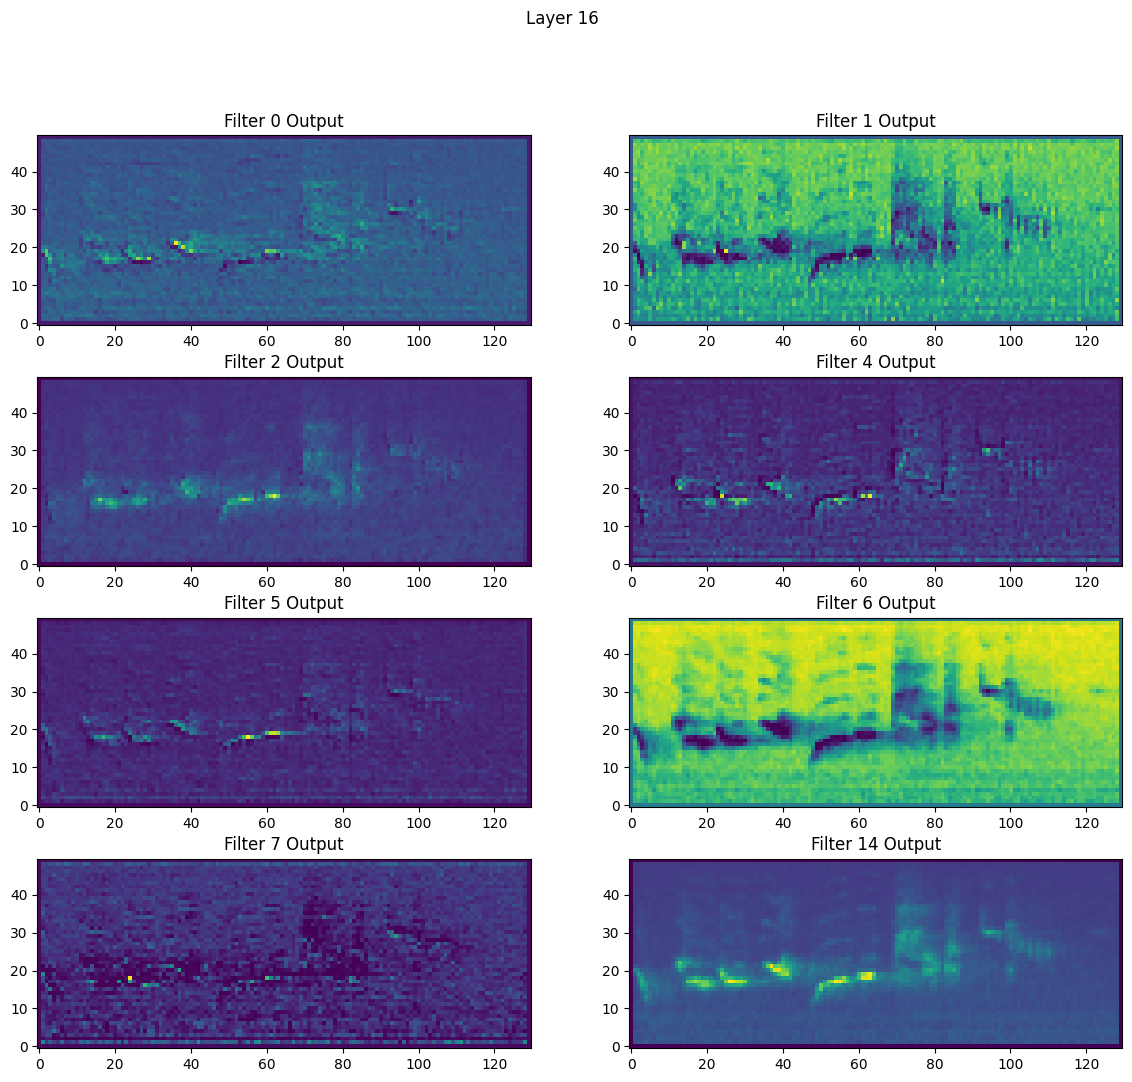

In [10]:


plt.figure(figsize=(14, 12))
for idx, i in enumerate([0, 1, 2, 4, 5, 6, 7, 14]):
    plt.subplot(4, 2, idx+1)
    plt.title(f'Filter {i} Output')
    m = tf.keras.models.Model(inputs=model.model.input, outputs=model.model.layers[16].output)
    p = m.predict(y[beg:end].reshape(1, -1, 1))[0,::-1,:,-i]

    plt.imshow(p, aspect='equal', cmap='viridis', origin='lower')
plt.suptitle('Layer 16')
plt.show()

embed = model.embeddings_model(y[beg:end].reshape(1, -1, 1))

## 🟨 Highlight Feature Regions
 
The above visualization shows the output of a specific convolutional layer. These outputs are feature maps, which are the result of convolving the input with learned filters.
Here we add a yellow patch to mark to represent such a filter.
This filter is then applied to the entire input, resulting in a lower dimensional representation of the input.

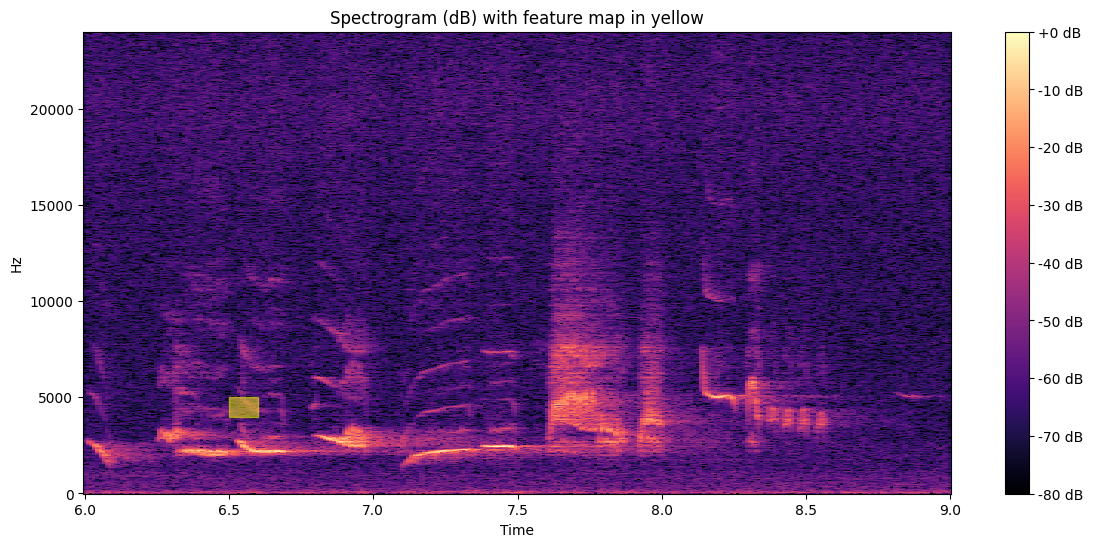

In [11]:
plt.figure(figsize=(14, 6))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
a, b = plt.xticks()
plt.gca().add_patch(plt.Rectangle((0.5, 4000), 0.1, 1000, color='yellow', alpha=0.5))
plt.xticks(a[1:-1], np.linspace(6, 9, 7))
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (dB) with feature map in yellow')
plt.show()

In [12]:
if False:
    import shap
    import numpy as np  
    import tensorflow as tf

    # Create sub-models
    mod_spec_input = tf.keras.models.Model(inputs=model.model.layers[4].input, outputs=model.model.output)
    spec_generator = tf.keras.models.Model(inputs=model.model.input, outputs=model.model.layers[2].output)

    print("spec_generator output shape:", x_input.shape)
    print("mod_spec_input expected input shape:", model.model.layers[2].input.shape)
    print("mod_spec_input expected input shape:", mod_spec_input.input.shape)


    # Get prediction and top classes
    predictions = model.model(y[beg:end].reshape(1, -1, 1))
    d = {idx: v for idx, v in enumerate(predictions.numpy()[0])}
    ds = dict(sorted(d.items(), key=lambda x: x[-1], reverse=True))
    best_classes = list(ds.keys())[:6]
    best_labels = {k: v for k, v in zip(best_classes, [labels.iloc[i, 0] for i in best_classes])}

    # Preprocess input into model-ready shape
    x_input = spec_generator(y[beg:end].reshape(1, -1, 1))

    # Run once to get prediction and check shape
    pred = mod_spec_input(x_input).numpy()
    print("Prediction shape:", pred.shape)  # (1, num_classes)

    # Class to explain (e.g. 6253)
    class_idx = 6253

    # Create GradientExplainer
    explainer = shap.GradientExplainer(mod_spec_input, x_input)

    # Compute SHAP values
    shap_vals = explainer.shap_values(x_input)

    # Extract SHAP values for desired class
    shap_class_vals = shap_vals[class_idx]  # shape: (1, time, 1)

    # Optional: plot the SHAP values
    shap.image_plot([shap_class_vals], x_input)


    explainer = shap.DeepExplainer(model.model, y[beg:end].reshape(1, -1, 1))
    shap_values = explainer.shap_values(y[beg:end].reshape(1, -1, 1))

## 🌍 Visualize Embeddings with UMAP
 
Load precomputed embeddings from many audio samples and reduce their dimensionality using UMAP.  
UMAP helps us see how audio clips of different species or sounds cluster together in 2D space.

In [13]:
import umap

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

source_folder = 'sources/embeds/2025-05-14_12-04___birdnet-20250503'
source_files = Path(source_folder).glob('*.npy')
df = pd.read_csv('sources/embeds/idxs2.csv', header=None)
labels = [labels_from_idx.iloc[pred, 0].split('_')[-1] 
          for pred in df.iloc[:, -1].values]
a, b = np.unique(labels, return_counts=True)
labels = np.array(labels)
for i, label in enumerate(a):
    if b[i] < 20:
        labels[np.array(labels) == label] = 'other'
embeds = []
for file in source_files:
    if '243B1F08641FDBB4_20250503_040000' in file.stem:
        continue
    embeds.append(np.load(file))
embeds = np.concatenate(embeds, axis=0)
embeds = embeds.reshape(embeds.shape[0], -1)

# Perform UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', random_state=42)
transformation = reducer.fit(embeds)
transformed_data = transformation.embedding_


c:\Users\vincent.kather\Documents\Code\computational-bioacoustics-notebooks\env_comp\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vincent.kather\Documents\Code\computational-bioacoustics-notebooks\env_comp\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


C:\Users\vincent.kather\AppData\Local\Temp\ipykernel_15256\1248593774.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('tab20')
C:\Users\vincent.kather\AppData\Local\Temp\ipykernel_15256\1248593774.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(transformed_data[np.array(labels) == label, 0],


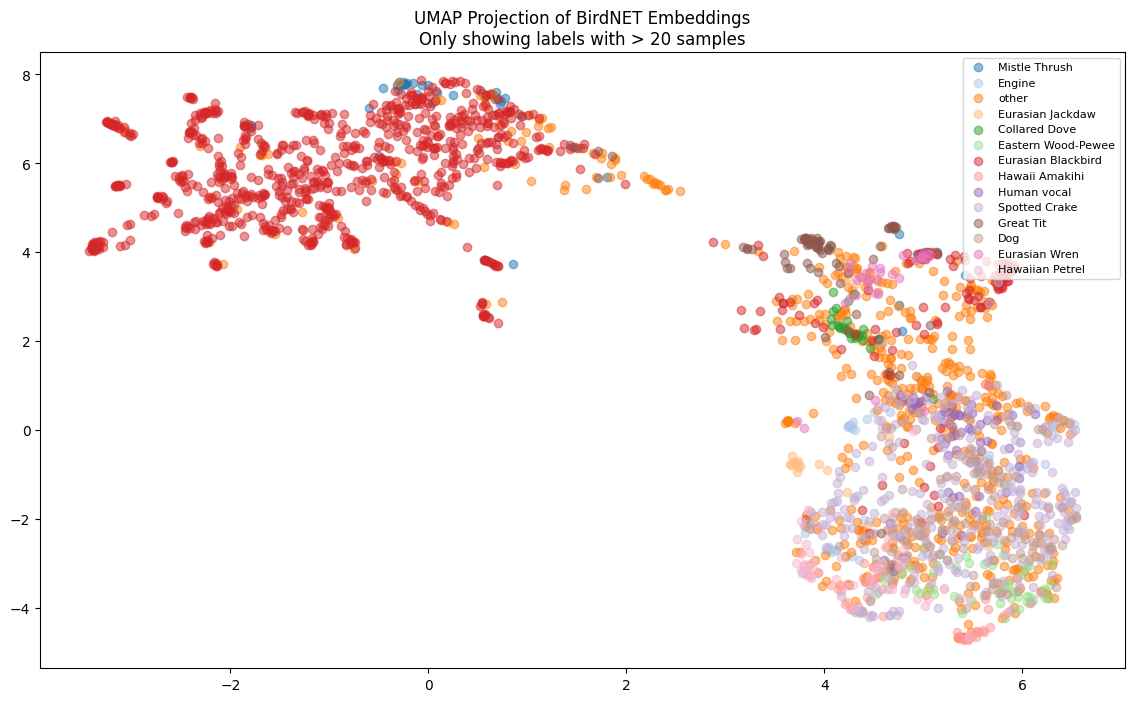

In [14]:

# Define colors for each label
cm = plt.cm.get_cmap('tab20')
# Plot UMAP
plt.figure(figsize=(14, 8))
for i, label in enumerate(set(labels)):
    plt.scatter(transformed_data[np.array(labels) == label, 0], 
                transformed_data[np.array(labels) == label, 1], 
                label=label, 
                c=cm(i),
                alpha=0.5)
plt.title('UMAP Projection of BirdNET Embeddings\nOnly showing labels with > 20 samples')
plt.legend(*plt.gca().get_legend_handles_labels(), loc='upper right', fontsize=8)
plt.show()




## 📍 Highlight Quiz Sound Examples
 
Load a few new sounds (e.g., from our sound quiz), compute their embeddings, and project them into the same UMAP space.  
This allows us to visually compare them with the rest of the dataset and see where they fall.


c:\Users\vincent.kather\Documents\Code\computational-bioacoustics-notebooks\env_comp\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vincent.kather\Documents\Code\computational-bioacoustics-notebooks\env_comp\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vincent.kather\Documents\Code\computational-bioacoustics-notebooks\env_comp\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vincent.kather\Documents\Code\computational-bioacoustics-notebooks\env_comp\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be r

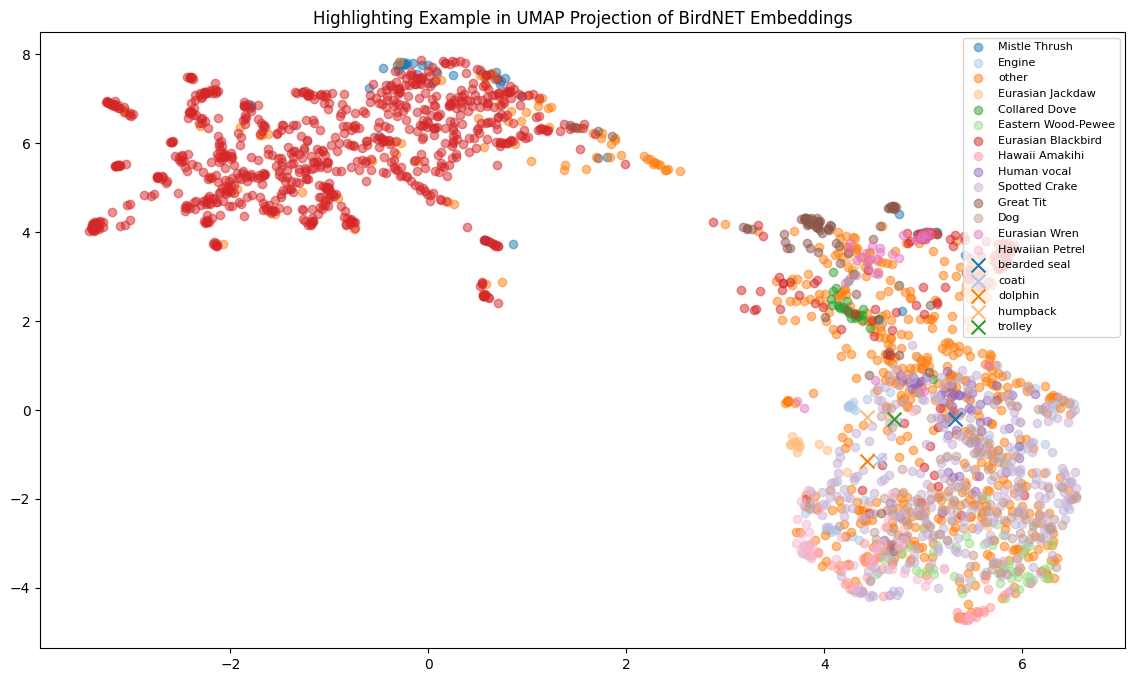

In [15]:
# Transform example from before
quiz_sounds_dir = r'G:\Work\NaturalisPhD\6_Presentations\1_My_Presentations\4_Other\2025\LeidenUniSources\audioQuiz'
quiz_sounds = ['bearded seal.wav', 'coati.wav', 'dolphin.wav', 'humpback.wav', 'trolley.wav']
transformed_examples = []
new_embeds = []
source_paths = []
for i, quiz_sound in enumerate(quiz_sounds):
    source_paths.append(Path(quiz_sounds_dir) / quiz_sound)
    y, sr = librosa.load(source_paths[i], sr=48000)
    y = librosa.util.fix_length(y, size=48000*3)
    new_embeds.append(model.embeddings_model(y.reshape(1, -1, 1)))

    # example_embed = np.load('sources/243B1F08641FDBB4_20250503_040000_birdnet.npy')
    transformed_examples.append(reducer.transform(new_embeds[i]))

# Define colors for each label
cm = plt.cm.get_cmap('tab20')
# Plot UMAP
plt.figure(figsize=(14, 8))
for i, label in enumerate(set(labels)):
    plt.scatter(transformed_data[np.array(labels) == label, 0], 
                transformed_data[np.array(labels) == label, 1], 
                label=label, 
                c=cm(i),
                alpha=0.5)
plt.title('Highlighting Example in UMAP Projection of BirdNET Embeddings')
for i, example in enumerate(transformed_examples):
    plt.scatter(example[:, 0], example[:, 1], c=cm(i), marker='x', s=100, label=Path(source_paths[i]).stem)
# plt.scatter(transformed_example[:, 0], transformed_example[:, 1], c='red', marker='x', s=100, label=Path(source_path).stem)
plt.legend(*plt.gca().get_legend_handles_labels(), loc='upper right', fontsize=8)
plt.show()
